# AFL Match Prediction

## Introduction

The Australian Football League (AFL) is one of the most watched and betted on sporting leagues in Australia.
In this project, we train a machine learning model to predict the outcome of an AFL game using data from 2000 to the current day.

We try several models: random forest classifier, logistic regression, state vector machines, and neural networks.

Based on our data and the chosen extracted features, logistic regression was found to be the best predictor.
When evaluated on the test set, containing matches from 2019 and later, this classifer had an accuracy of 65.77%.

## Obtaining Data

First we will use the PyAFL package to extract data on AFL matches.

In [93]:
from pyAFL.seasons.models import Season

season_dfs = []
columns = ['Date', 'Home team', 'Away Team','Home team score', 'Away team score']

for year in range(2000,2023):
       stats = Season(year).get_season_stats().match_summary
       season_dfs.append(stats[columns])

match_df = pd.concat(season_dfs)


The following is function to calculate some basic features which we will use in our machine learning model.
The features we calculate are as follows (each statistic is calculated for both the home and away team):

- The number of points scored by and against the team in the current season.
- The average number of points scored by and against the team in the last n games, with n ranging from 1 to 5.
- The performance of the team in the current season. Performance is calculated as follows: 2 points is given for a win, 1 point for a draw, and zero points for a loss.
- The average performance of the team in the last n games, with n ranging from 1 to 5.
- The position of the team in a ranking of all the teams based on their performance this season.

In [1]:
import pandas as pd

def processAFLData(source):

    # Read CSV and convert date to the correct format
    columns = ["Game", "Season", "Date", "Round", "Home_Team", "Home_Points", "Away_Team", "Away_Points"]
    afl_df = pd.read_csv(source, usecols = columns)
    afl_df["Date"] = pd.to_datetime(afl_df["Date"])

    # Add a column which says whether the home or away team won (or a draw)
    afl_df["Winner"] = "Home"
    afl_df.loc[afl_df["Home_Points"] < afl_df["Away_Points"], "Winner"] = "Away"
    afl_df.loc[afl_df["Home_Points"] == afl_df["Away_Points"], "Winner"] = "Draw"

    # Create new dataframe 'teams_df', containing the match data for individual teams.
    # Start by getting the home teams.
    homeCols = ["Game", "Season", "Date", "Round", "Home_Team", "Home_Points", "Away_Points"]
    colNames = {"Home_Team":"Team", "Home_Points":"PointsBy", "Away_Points":"PointsAgainst"}
    home_df = afl_df[homeCols].rename(columns = colNames)
    home_df["Home/Away"] = "Home"
    home_df["Winner"] = afl_df["Winner"]

    # Now get the away teams and add it to the dataframe
    awayCols = ["Game", "Season", "Date", "Round", "Away_Team", "Away_Points", "Home_Points"]
    colNames = {"Away_Team":"Team", "Away_Points":"PointsBy", "Home_Points":"PointsAgainst"}
    away_df = afl_df[awayCols].rename(columns = colNames)
    away_df["Home/Away"] = "Away"
    away_df["Winner"] = afl_df["Winner"]

    # Join home and away teams together and sort by date
    teams_df = pd.concat([home_df, away_df]).sort_values(by = "Date", ignore_index=True)

    # Add a column which gives the performance score for the team's game
    # Two points for a win, one for a draw, and none for a loss
    teams_df['Performance'] = 2*(teams_df['Home/Away'] == teams_df["Winner"]) + (teams_df['Home/Away'] == "Draw")

    # Calculate the statistics, starting with the ones that are based on the current season.
    seasons = teams_df.groupby(['Team', 'Season'])
    teams_df['SeasonPointsBy'] = seasons['PointsBy'].cumsum() - teams_df['PointsBy']
    teams_df['SeasonPointsAgainst'] = seasons['PointsAgainst'].cumsum() - teams_df['PointsAgainst']  
    teams_df['SeasonPerformance'] = seasons['Performance'].cumsum() - teams_df['Performance']

    # Relative ranking of team by performance in season (higher rank means better performance).
    roundGroups = teams_df.groupby(['Season', 'Round'])
    teams_df['Ranking'] = roundGroups['SeasonPerformance'].rank("dense")

    # Now the stats that only depend on the team
    teamGroups = teams_df.groupby(['Team'])

    # Average points by, points against, and performance for a team in the last n=1...5 games
    for n in range(1,6):
        teams_df[('PointsBy_Last_' + str(n))] = teamGroups['PointsBy'].transform(lambda x: x.rolling(n,1).mean().shift())
        teams_df[('PointsAgainst_Last_' + str(n))] = teamGroups['PointsAgainst'].transform(lambda x: x.rolling(n,1).mean().shift())
        teams_df[('Performance_Last_' + str(n))] = teamGroups['Performance'].transform(lambda x: x.rolling(n,1).mean().shift())

    # Put the data back together so that each row corresponds to a game with a home and away team
    # Start by separating home and away teams and adding 'Home' or 'Away' prefix to column names
    teams_df = teams_df.drop(columns = ['PointsAgainst', 'Performance'])
    unchangedCols = ['Game', 'Season', 'Date', 'Round', 'Winner', 'Home/Away']
    oldColNames = [name for name in teams_df.columns if name not in unchangedCols]

    homeStats = teams_df[teams_df['Home/Away'] == 'Home'].drop(columns = ['Home/Away'])
    homeStats = homeStats.rename(columns = dict(zip(oldColNames, ['Home_' + name for name in oldColNames])))
    awayStats = teams_df[teams_df['Home/Away'] == 'Away'].drop(columns = ['Home/Away'])
    awayStats = awayStats.rename(columns = dict(zip(oldColNames, ['Away_' + name for name in oldColNames])))

    matchStats = pd.merge(homeStats, awayStats, on = ['Game', 'Season', 'Date', 'Round', 'Winner'])
    
    return matchStats

In [2]:
afl_df = processAFLData('afl_matches.csv')

Some notes on these features:

- All of these features can be calculated before a game is played and therefore can be used to predict the outcome of a given match.
- One could get much more granular with the features, for example by considering the number of specific goals and behinds, hte number of possessions, etc. It would be worth considering such features and doing a more detailed exploration of possible features to see whether they result in more accurate models. For now, we keep it simple.
- To reduce the number of features, one could use the difference between the home and away team statistics. We did try this in a parallel analysis but found that it lead to poorer results, so we haven't included this in the discussion.


## Data exploration

In [3]:
afl_df.shape

(4463, 47)

In [4]:
afl_df.head()

,Game,Season,Date,Round,Home_Team,Home_PointsBy,Winner,Home_SeasonPointsBy,Home_SeasonPointsAgainst,Home_SeasonPerformance,...,Away_Performance_Last_2,Away_PointsBy_Last_3,Away_PointsAgainst_Last_3,Away_Performance_Last_3,Away_PointsBy_Last_4,Away_PointsAgainst_Last_4,Away_Performance_Last_4,Away_PointsBy_Last_5,Away_PointsAgainst_Last_5,Away_Performance_Last_5
0,11728,2000,2000-03-08,R1,Richmond,94,Home,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,11729,2000,2000-03-09,R1,Essendon,156,Home,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,11730,2000,2000-03-10,R1,North Melbourne,111,Away,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,11731,2000,2000-03-11,R1,Adelaide,108,Away,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,11732,2000,2000-03-11,R1,Fremantle,107,Away,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
afl_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4463 entries, 0 to 4462
Data columns (total 47 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Game                       4463 non-null   int64         
 1   Season                     4463 non-null   int64         
 2   Date                       4463 non-null   datetime64[ns]
 3   Round                      4463 non-null   object        
 4   Home_Team                  4463 non-null   object        
 5   Home_PointsBy              4463 non-null   int64         
 6   Winner                     4463 non-null   object        
 7   Home_SeasonPointsBy        4463 non-null   int64         
 8   Home_SeasonPointsAgainst   4463 non-null   int64         
 9   Home_SeasonPerformance     4463 non-null   int32         
 10  Home_Ranking               4463 non-null   float64       
 11  Home_PointsBy_Last_1       4453 non-null   float64       
 12  Home_P

There are 8 missing values in each of the 'rolling average' statistics, because these can't be calculated until after a team has played thier first match.

There are two additional missing values: this is because two new teams were added to the AFL.
Gold Coast Suns were added in 2011 and Greater Western Sydney was added in 2012.

In [6]:
afl_df.describe()

,Game,Season,Home_PointsBy,Home_SeasonPointsBy,Home_SeasonPointsAgainst,Home_SeasonPerformance,Home_Ranking,Home_PointsBy_Last_1,Home_PointsAgainst_Last_1,Home_Performance_Last_1,...,Away_Performance_Last_2,Away_PointsBy_Last_3,Away_PointsAgainst_Last_3,Away_Performance_Last_3,Away_PointsBy_Last_4,Away_PointsAgainst_Last_4,Away_Performance_Last_4,Away_PointsBy_Last_5,Away_PointsAgainst_Last_5,Away_Performance_Last_5
count,4463.000000,4463.000000,4463.000000,4463.000000,4463.000000,4463.000000,4463.000000,4453.000000,4453.000000,4453.000000,...,4455.000000,4455.000000,4455.000000,4455.000000,4455.000000,4455.000000,4455.000000,4455.000000,4455.000000,4455.000000
mean,13959.000000,2011.233475,93.222720,999.803719,978.481067,11.315259,4.042796,87.402425,91.265888,0.918033,...,1.018631,90.238683,88.911635,1.019005,89.995155,89.288739,1.005761,89.982103,89.348784,1.004280
std,1288.501455,6.601426,28.158595,648.015951,606.278774,9.247668,2.503105,28.057759,28.348473,0.996747,...,0.740977,19.103399,19.720215,0.636606,17.550481,18.365747,0.574723,16.556606,17.483370,0.533337
min,11728.000000,2000.000000,16.000000,0.000000,0.000000,0.000000,1.000000,13.000000,19.000000,0.000000,...,0.000000,36.333333,31.000000,0.000000,36.000000,36.500000,0.000000,37.000000,40.200000,0.000000
25%,12843.500000,2006.000000,73.000000,458.500000,463.500000,4.000000,2.000000,67.000000,71.000000,0.000000,...,0.000000,77.333333,75.000000,0.666667,78.250000,76.500000,0.500000,79.000000,77.200000,0.800000
50%,13959.000000,2011.000000,92.000000,955.000000,955.000000,10.000000,4.000000,85.000000,89.000000,0.000000,...,1.000000,89.666667,88.000000,1.333333,89.250000,88.250000,1.000000,89.600000,88.200000,1.200000
75%,15074.500000,2017.000000,111.000000,1480.000000,1467.000000,18.000000,6.000000,105.000000,110.000000,2.000000,...,2.000000,102.333333,101.000000,1.333333,101.000000,100.500000,1.500000,100.800000,100.400000,1.200000
max,16190.000000,2022.000000,233.000000,3139.000000,2681.000000,46.000000,13.000000,233.000000,198.000000,2.000000,...,2.000000,178.000000,171.000000,2.000000,166.750000,171.000000,2.000000,153.000000,171.000000,2.000000


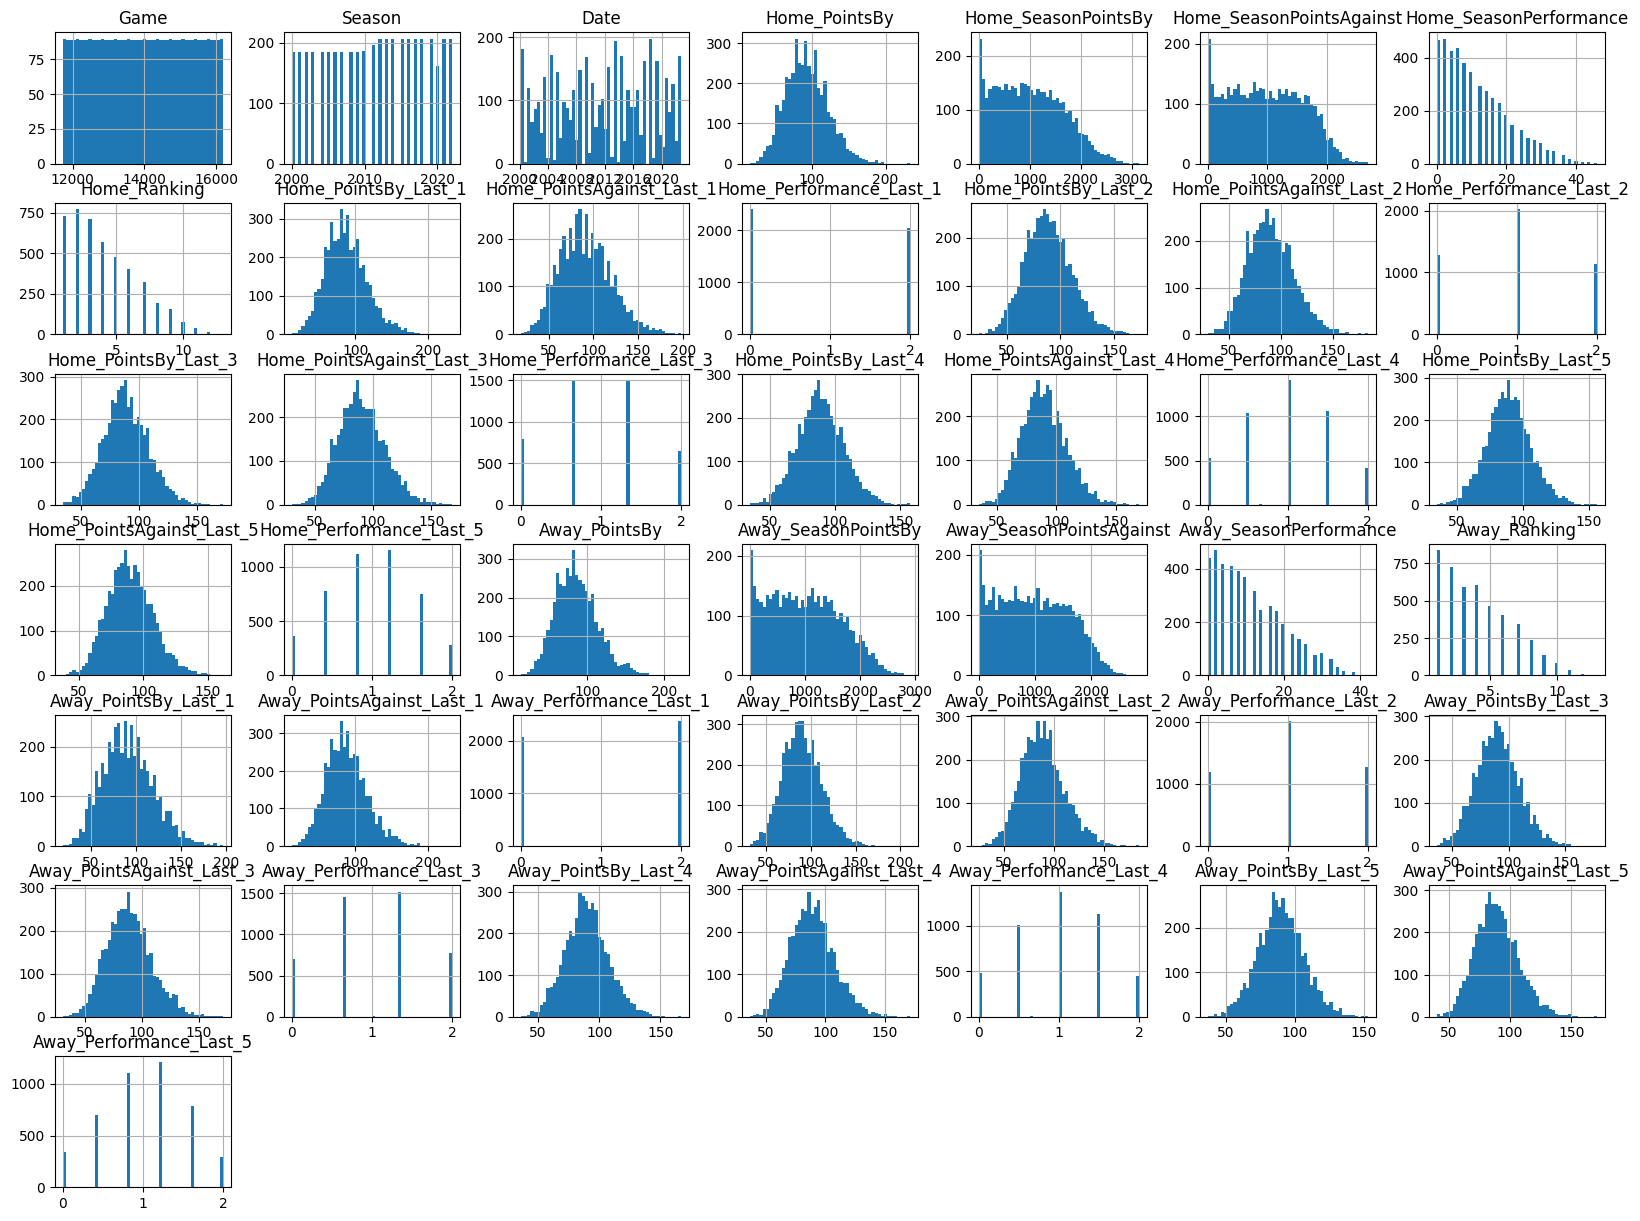

In [7]:
import matplotlib.pyplot as plt
afl_df.hist(bins=50, figsize=(20,15))
plt.show()

Most variables are normally distributed. The exceptions are the ranking and the season performance.

The seasonal points have higher values, because it's a cumulative sum and no average is taken.

Rankings are more likely to be lower, because it's a dense ranking. Earlier in the season most teams will have similar rankings; only later in the season do we have higher rankings.

In the Season graph we see the effect of COVID-19; less games were played in 2020. 
You can also see the addition of new teams in 2011 and 2012.

## Create training and test set

We use matches played before 2019 as the training set.

In [8]:
# Create a training and test set.
# Use games played before 2019 as the training set.
train_set = afl_df[afl_df['Season'] < 2019]
test_set = afl_df[afl_df['Season'] >= 2019]

## Data preparation

In [9]:
# Want out sklearn classes to return pandas dataframes, not numpy arrays
from sklearn import set_config
set_config(transform_output = "pandas")

We will create a data transformer to prepare our data. 

To prepare the data, we simply remove the columns that we don't want to use in our training (such as the ones we can't know before a match is played).

There are not many NA values, so we simply drop them.

In [10]:
from sklearn.base import BaseEstimator, TransformerMixin

game_ix, season_ix, date_ix, round_ix, hometeam_ix = 0, 1, 2, 3, 4 
homepoints_ix, winner_ix, awayteam_ix, away_points_ix = 5, 6, 26, 27
cols_to_drop = [game_ix, season_ix, date_ix, round_ix, hometeam_ix, winner_ix, awayteam_ix, homepoints_ix, away_points_ix]

class AFLDataPrepper(BaseEstimator, TransformerMixin):
    def __init__(self, dropNA = True):
        self.dropNA = dropNA

    def fit(self, X, y=None):
        return self

    def transform(self, X):

        # Only want to use features that we can know before the game is played
        X = X.drop(X.columns[cols_to_drop], axis=1)

        # Remove rows with missing values
        if self.dropNA:
            X = X.dropna()

        return X    

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

afl_pipeline = Pipeline([
    ('afl_prepper', AFLDataPrepper()),
    ('std_scaler', StandardScaler())
])


In [12]:
def get_labels(train_set, drop_na = True):
    if drop_na:
        return train_set.dropna()["Winner"]
    return train_set["Winner"]

In [13]:
# Transform the data and get the labels
afl_prepared = afl_pipeline.fit_transform(train_set.copy())
train_labels = get_labels(train_set)

## Selecting and training a model

In [14]:
from sklearn.model_selection import cross_val_score
import numpy as np

def evaluate_model(model, train, labels, k=3):
    accuracy = cross_val_score(model, train, labels, cv=k, scoring = "accuracy")
    print("Accuracy = {:0.2f}%".format(np.mean(accuracy)*100))


#### Random Forest Classifier

In [15]:
from sklearn.ensemble import RandomForestClassifier
afl_rf = RandomForestClassifier()
afl_rf.fit(afl_prepared, train_labels)

RandomForestClassifier()

In [16]:
evaluate_model(afl_rf, afl_prepared, train_labels)

Accuracy = 63.68%


In [19]:
# Fine tune the parameters with randomised grid search.
from sklearn.model_selection import RandomizedSearchCV

In [20]:
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [10, 20, 30],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [100, 200, 500]
}

rand_search_cv = RandomizedSearchCV(estimator=afl_rf,
                                    param_distributions=param_grid,
                                    cv=5,
                                    n_iter=100,
                                    random_state=42)

rand_search_cv.fit(afl_prepared, train_labels)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=100,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 500]},
                   random_state=42)

This took about half an hour to do. Let's see the results:

In [21]:
rand_search_cv.best_params_

{'n_estimators': 500,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_depth': 20,
 'bootstrap': True}

In [22]:
best_rf = rand_search_cv.best_estimator_

In [24]:
evaluate_model(best_rf, afl_prepared, train_labels)

Accuracy = 65.09%


Some of the best parameters were the maximum values, so possible we'd improve the model by increasing these parameters. For this reason we will do a second search.

In [21]:
param_grid2 = {
    'bootstrap': [True, False],
    'max_depth': [15, 20, 25],
    'min_samples_leaf': [2, 3],
    'min_samples_split': [10, 20, 30],
    'n_estimators': [400, 500, 750, 1000]
}

rand_search_cv2 = RandomizedSearchCV(estimator=afl_rf,
                                    param_distributions=param_grid2,
                                    cv=5,
                                    n_iter=100,
                                    random_state=42)

rand_search_cv2.fit(afl_prepared, train_labels)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=100,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [15, 20, 25],
                                        'min_samples_leaf': [2, 3],
                                        'min_samples_split': [10, 20, 30],
                                        'n_estimators': [400, 500, 750, 1000]},
                   random_state=42)

In [22]:
rand_search_cv2.best_params_

{'n_estimators': 1000,
 'min_samples_split': 30,
 'min_samples_leaf': 3,
 'max_depth': 20,
 'bootstrap': True}

In [23]:
evaluate_model(rand_search_cv2.best_estimator_, afl_prepared, train_labels)

Accuracy = 65.17%


n_estimators and min_samples_split are still at their max values, so we could do another search.

However, the previous search only resulted in a very modest increase in accuracy, so we'll leave the fine tuning here for now.

#### Logistic Regression

In [17]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=500)
log_reg.fit(afl_prepared, train_labels)

LogisticRegression(max_iter=500)

In [18]:
evaluate_model(log_reg, afl_prepared, train_labels)

Accuracy = 64.82%


So, out of the box this seems to at least do as well as the random forest classifier.

#### Support Vector Machine

In [43]:
from sklearn.svm import LinearSVC
linearSVC = LinearSVC(C=0.001, loss='hinge')

In [44]:
evaluate_model(linearSVC, afl_prepared, train_labels)

Accuracy = 65.29%


In [21]:
# Polynomial SVM
from sklearn.svm import SVC
poly_svm = SVC(kernel = "poly", degree=3, C=0.0001)
evaluate_model(poly_svm, afl_prepared, train_labels)

Accuracy = 57.55%


So higher degree polynomials don't appear to do a better job.

#### Neural networks

In [22]:
import tensorflow as tf 
from tensorflow import keras

In [23]:
# Neural networks need integer labels
bin_labels = (train_labels == "Home").astype('int')

In [26]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3):
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape=(38,)))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(1, activation="sigmoid"))
    optimizer = keras.optimizers.Adam(learning_rate)
    model.compile(loss=keras.losses.binary_crossentropy, optimizer=optimizer)
    return model

In [89]:
from scikeras.wrappers import KerasClassifier

keras_clf = KerasClassifier(
    model=build_model,
    n_hidden=1,
    n_neurons=30,
    learning_rate = 3e-3
)
evaluate_model(keras_clf, afl_prepared, bin_labels)

39/39 [==============================] - 0s 1ms/step
Accuracy = 64.39%


In [91]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_hidden": [1,2,3,4],
    "n_neurons": [10,20,30],
    "learning_rate": reciprocal(3e-4, 3e-2)
}
rnd_search_cv = RandomizedSearchCV(keras_clf, param_distribs, n_iter=10, cv=3)
rnd_search_cv.fit(afl_prepared, bin_labels, epochs=100,
                  validation_split=0.2,
                  verbose=0)


39/39 [==============================] - 0s 1ms/step


RandomizedSearchCV(cv=3,
                   estimator=KerasClassifier(learning_rate=0.003, model=<function build_model at 0x0000015BE74B8550>, n_hidden=1, n_neurons=30),
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000015BF0D4C580>,
                                        'n_hidden': [1, 2, 3, 4],
                                        'n_neurons': [10, 20, 30]})

In [92]:
rnd_search_cv.best_params_

{'learning_rate': 0.0017120646387156207, 'n_hidden': 1, 'n_neurons': 20}

In [93]:
evaluate_model(rnd_search_cv.best_estimator_, afl_prepared, bin_labels)

39/39 [==============================] - 0s 1ms/step
Accuracy = 63.11%


In [94]:
evaluate_model(KerasClassifier(model=build_model, n_hidden=1), afl_prepared, bin_labels)

39/39 [==============================] - 0s 1ms/step
Accuracy = 64.58%


### Ensemble Methods

So we have four models, each achieving an accuracy of about 65%.

Now we'll see if we can combine them to produce an even more accurate model.

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
import tensorflow as tf 
from tensorflow import keras
from scikeras.wrappers import KerasClassifier

In [27]:
rf_clf = RandomForestClassifier()
log_clf = LogisticRegression(max_iter=500)
svm_clf = LinearSVC(C=0.001, loss='hinge')
keras_clf = KerasClassifier(
    model=build_model,
    n_hidden=1,
    n_neurons=30,
    learning_rate = 7e-4
)

In [28]:
bin_labels = (train_labels == "Home").astype('int')

To establish a baseline, let's evaluate our current models:

In [29]:
for clf in (rf_clf, log_clf, svm_clf, keras_clf):
    print(clf.__class__.__name__, ":")
    evaluate_model(clf, afl_prepared, bin_labels)

RandomForestClassifier :
Accuracy = 65.53%
LogisticRegression :
Accuracy = 65.31%
LinearSVC :
Accuracy = 65.64%
KerasClassifier :
39/39 [==============================] - 0s 2ms/step
Accuracy = 63.43%


So our svm and logistic regresssion models are our best. 
Let's see if we can improve them using some ensemble methods.

### Voting classifier

In [40]:
from sklearn.ensemble import VotingClassifier

In [50]:
voting_clf = VotingClassifier(
    estimators=[('rf', rf_clf), ('lr', log_clf), ('svm', svm_clf), ('nn', keras_clf)],
    voting='hard'
)
evaluate_model(voting_clf, afl_prepared, bin_labels)

39/39 [==============================] - 0s 1ms/step
Accuracy = 65.26%


So the voting classifier doesn't give better results. 
Try with soft voting:

In [54]:
voting_soft_clf = VotingClassifier(
    estimators=[('rf', rf_clf), ('lr', log_clf), ('nn', keras_clf)],
    voting='soft'
)
evaluate_model(voting_soft_clf, afl_prepared, bin_labels)

39/39 [==============================] - 0s 993us/step
Accuracy = 65.31%


Note that the LinearSVM classifier doesn't predict probabilities and can't be included in the soft voting model.
We see that using soft voting with all of the other classifiers gives us an accuracy that is almost as good as the SVM model.


### Bagging

Logistic regression is one of our best classifiers, so let's try an ensemble method to improve it.

In [61]:
from sklearn.ensemble import BaggingClassifier

bag_log_clf = BaggingClassifier(
    LogisticRegression(max_iter=500), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1
)
evaluate_model(bag_log_clf, afl_prepared, bin_labels)

Accuracy = 65.53%


So bagging appears to slightly improve the logistic regression classifier, but a lot longer to train.

Let's try the SVM:

In [63]:
bag_svm_clf = BaggingClassifier(
    LinearSVC(C=0.001, loss='hinge'), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1
)
evaluate_model(bag_svm_clf, afl_prepared, bin_labels)

Accuracy = 64.39%


So bagging doesn't improve the LinearSVC.

### Boosting

In [66]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    log_clf, n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5
)
evaluate_model(ada_clf, afl_prepared, bin_labels)

Accuracy = 65.37%


Not bad, but not much better than logistic regression by itself.

In [67]:
import xgboost

xgb_clf = xgboost.XGBClassifier()
evaluate_model(xgb_clf, afl_prepared, bin_labels)

Accuracy = 62.83%


So gradient boosting doesn't seem like a good prospect.

## Evaluating on test set

Our best performing models are the LinearSVC and logistic regression. 
Let's see how they do on the test set.

In [45]:
from sklearn.metrics import accuracy_score

testX = afl_pipeline.fit_transform(test_set.copy())
test_labels = get_labels(test_set.copy())

log_clf = LogisticRegression(max_iter=500)
svm_clf = LinearSVC(C=0.001, loss='hinge')

for clf in (log_clf, svm_clf):
    clf.fit(afl_prepared, train_labels)
    preds = clf.predict(testX)
    print(clf.__class__.__name__)
    print("Accuracy = {:0.2f}%".format(accuracy_score(test_labels, preds)*100))

LogisticRegression
Accuracy = 65.26%
LinearSVC
Accuracy = 63.35%


So logistic regression does marginally better.

## Launching the model

We want to be able to make actual predictions for future games, so we will create a class to do this.

In [ ]:
class AFLPredictor:
    def __init__(estimator, ):
        self.estimator = estimator
    

## Conclusion

The models that performed the best were logistic regression and a linear SVM, both achieving about 65% accuracy on the test set.

Of the four main models tested, neural networks performed the worst. 
However, such models required a significant amount of tuning to perform well and the training dataset isn't particularly large.
It is possible that with proper tuning one could achieve better performance with deep learning.